In [2]:
import os
import cv2

import torch
from torch import nn

from torchvision import tv_tensors
from torchvision.io import read_image
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2
from torchvision.transforms import v2 as T
from torchvision.utils import draw_bounding_boxes
from scipy.ndimage import convolve

from tqdm import tqdm

from transformers import AutoModelForImageClassification, AutoImageProcessor, AutoConfig, TrainingArguments, Trainer
from transformers import DefaultDataCollator
from datasets import Dataset, DatasetDict
import evaluate

from collections import Counter
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 


In [3]:
from datasets import load_dataset

ds = load_dataset("uoft-cs/cifar100")

README.md:   0%|          | 0.00/9.98k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 10000
    })
})

## Конвертируем датасет с новыми лейблами

In [5]:
oldidx2label = {48: "motorcycle", 8: "bicycle"}
label2id = {"motorcycle": 0, "bicycle": 1, "background": 2}
id2label = {0: "motorcycle", 1: "bicycle", 2: "background"}

In [6]:
dict_hf_dataset = {'pixel_values': [], 'label': [], 'original_label': []}
for item in tqdm(ds['train']):
    dict_hf_dataset['pixel_values'].append(item['img'])

    original_classes_data = {}
    
    if item['fine_label'] in [8, 48]:
        label_class = oldidx2label[item['fine_label']]
        new_idx = label2id[label_class]
    else:
        new_idx = label2id['background']
    
    dict_hf_dataset['label'].append(new_idx)
    dict_hf_dataset['original_label'].append(item['fine_label'])
    
train_dataset = Dataset.from_dict(dict_hf_dataset)

dict_hf_dataset = {'pixel_values': [], 'label': [], 'original_label': []}
for item in tqdm(ds['test']):
    dict_hf_dataset['pixel_values'].append(item['img'])
    
    
    if item['fine_label'] in [8, 48]:
        label_class = oldidx2label[item['fine_label']]
        new_idx = label2id[label_class]
    else:
        new_idx = label2id['background']

    dict_hf_dataset['label'].append(new_idx)
    dict_hf_dataset['original_label'].append(item['fine_label'])

test_dataset = Dataset.from_dict(dict_hf_dataset)

100%|██████████| 10000/10000 [00:02<00:00, 4006.28it/s]


## Ребалансируем классы, так что 
## 'motorcycle' = 500, 
## 'bicycle' = 500, 
## 'background' ~= 1000 (при этом классы входящие в background равномерно распределены)

In [7]:
dict_hf_dataset = {'pixel_values': [], 'label': [], 'original_label': []}

for i in tqdm(range(0, 100)):
    class_indexes = np.where(np.array(ds['train']['fine_label']) == i)[0]
    
    if i not in [8, 48]:
        class_indexes = np.where(np.array(ds['train']['fine_label']) == i)[0]
        choosen_idx = np.random.randint(0, len(class_indexes), 11)
        for idx in choosen_idx:
            idx = idx.item()
            dict_hf_dataset['pixel_values'].append(ds['train'][idx]['img'])
            dict_hf_dataset['label'].append(2)
            dict_hf_dataset['original_label'].append(ds['train'][idx]['fine_label'])
    else:
        for idx in class_indexes:
            idx = idx.item()
            dict_hf_dataset['pixel_values'].append(ds['train'][idx]['img'])
            label_class = oldidx2label[ds['train'][idx]['fine_label']]
            new_idx = label2id[label_class]
            dict_hf_dataset['label'].append(new_idx)
            dict_hf_dataset['original_label'].append(ds['train'][idx]['fine_label'])
        
filtered_train_dataset = Dataset.from_dict(dict_hf_dataset) 

100%|██████████| 100/100 [00:05<00:00, 16.69it/s]


In [8]:
train_dataset

Dataset({
    features: ['pixel_values', 'label', 'original_label'],
    num_rows: 50000
})

In [9]:
filtered_train_dataset

Dataset({
    features: ['pixel_values', 'label', 'original_label'],
    num_rows: 2078
})

In [10]:
labels = ["motorcycle", "bicycle", "background"]
labels

['motorcycle', 'bicycle', 'background']

## Потренируем самый базовый pretrain ViT из HF

In [11]:
ckpt = "google/vit-base-patch16-224"

image_processor = AutoImageProcessor.from_pretrained(ckpt)
model = AutoModelForImageClassification.from_pretrained(
    ckpt,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

model.to('cuda');

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
normalize = v2.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
#TODO: add more augs
_train_transforms = v2.Compose([
    v2.Resize(size, interpolation=v2.InterpolationMode.BICUBIC),
    v2.ColorJitter(brightness=0.75, hue=0.5), 
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomAffine(degrees=(0, 20)),
    v2.ToTensor(),
    T.ToDtype(torch.float32, scale=1),
    normalize
])
_test_transforms = v2.Compose([v2.Resize(size, interpolation=v2.InterpolationMode.BICUBIC), v2.ToTensor(), normalize])

def train_transforms(example):
    example["pixel_values"] = _train_transforms(example['pixel_values'])
    return example

def test_transforms(example):
    example["pixel_values"] = _test_transforms(example['pixel_values'])
    return example

data_collator = DefaultDataCollator()

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [13]:
train_dataset = train_dataset.with_transform(train_transforms)
filtered_train_dataset = filtered_train_dataset.with_transform(train_transforms)
test_dataset = test_dataset.with_transform(test_transforms)

## Метрики будут: 
## - balanced_accuracy_scor - т.к. классы не сбалансированы
## - f1_score(average="weighted") - по той же причине

In [14]:
from sklearn.metrics import balanced_accuracy_score, f1_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        "acc": balanced_accuracy_score(y_true=labels, y_pred=predictions), #use balanced acc because of unbanaced classes
        'f1': f1_score(y_true=labels, y_pred=predictions, average="weighted") 
    }

In [15]:
training_args = TrainingArguments(
    output_dir="cifar_vit_vechicle_0",
    remove_unused_columns=True,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_acc",
    report_to='tensorboard',
    logging_dir='vit_224'
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=filtered_train_dataset,
    eval_dataset=test_dataset,
    processing_class=image_processor,
    compute_metrics=compute_metrics,
)

## Сначала посмотрим на zero-shot

In [16]:
preds = trainer.predict(test_dataset)

In [17]:
preds

PredictionOutput(predictions=array([[ 0.7502283 ,  0.72732866, -0.10191534],
       [ 0.76438725,  0.3607356 , -0.78790855],
       [ 0.71235853, -0.00523525,  0.11119999],
       ...,
       [ 0.34193963,  0.8122846 ,  0.8201362 ],
       [ 0.12046784,  0.7787414 ,  0.15110639],
       [ 1.5793881 ,  0.29717553,  0.4011863 ]], dtype=float32), label_ids=array([2, 2, 2, ..., 2, 2, 2]), metrics={'test_loss': 1.3354370594024658, 'test_model_preparation_time': 0.0039, 'test_acc': 0.5529251700680272, 'test_f1': 0.36519689333673605, 'test_runtime': 74.2424, 'test_samples_per_second': 134.694, 'test_steps_per_second': 8.418})

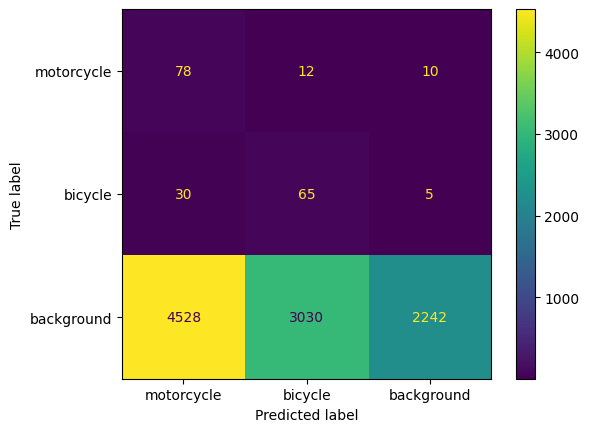

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(preds.label_ids, np.argmax(preds.predictions, axis=1), labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["motorcycle", "bicycle", "background"])
disp.plot()
plt.show()

In [21]:
{
    "acc": balanced_accuracy_score(y_true=preds.label_ids, y_pred=np.argmax(preds.predictions, axis=1)), 
    'f1': f1_score(y_true=preds.label_ids, y_pred=np.argmax(preds.predictions, axis=1), average="weighted") 
}

{'acc': 0.5529251700680272, 'f1': 0.36519689333673605}

## Получилось так себе, теперь натреним ViT

In [22]:
trainer.train()

Step,Training Loss,Validation Loss,Model Preparation Time,Acc,F1
50,0.262100,0.173247,0.003900,0.978027,0.986160
100,0.136200,0.131001,0.003900,0.972687,0.989102
150,0.091300,0.077864,0.003900,0.981156,0.993625
200,0.101200,0.094161,0.003900,0.972891,0.989530
250,0.046800,0.071324,0.003900,0.974252,0.992812
300,0.079300,0.063247,0.003900,0.970884,0.992627


TrainOutput(global_step=325, training_loss=0.18120119988918304, metrics={'train_runtime': 692.6186, 'train_samples_per_second': 15.001, 'train_steps_per_second': 0.469, 'total_flos': 8.051489883266458e+17, 'train_loss': 0.18120119988918304, 'epoch': 5.0})

In [23]:
preds = trainer.predict(test_dataset)

## Метрики на тестовой датасете (как видно модель хорошо нафайнтюнилась)

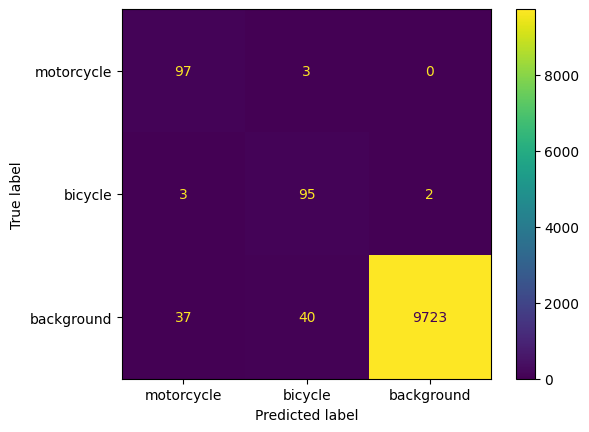

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(preds.label_ids, np.argmax(preds.predictions, axis=1), labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["motorcycle", "bicycle", "background"])
disp.plot()
plt.show()

In [25]:
{
    "acc": balanced_accuracy_score(y_true=preds.label_ids, y_pred=np.argmax(preds.predictions, axis=1)), 
    'f1': f1_score(y_true=preds.label_ids, y_pred=np.argmax(preds.predictions, axis=1), average="weighted") 
}

{'acc': 0.9707142857142856, 'f1': 0.992203674430436}

## Давайте убедимся, что модель реально справляется

In [30]:
def plot_model_preds(gt, preds, ds, plot_cmap=None):
    motocycle_in_gt = np.where(gt == 0)[0]
    bicycle_in_gt = np.where(gt == 1)[0]
    back_in_gt = np.where(gt == 2)[0]
    
    fig, axs = plt.subplots(3, 3, figsize=(13, 13))
    
    for idx, pred_class in enumerate([motocycle_in_gt, bicycle_in_gt, back_in_gt]):
        random_idx = np.random.randint(0, len(pred_class), 3)
        for j in range(3):
            npimg = ds[pred_class[random_idx[j]].item()]['pixel_values'].numpy()
            axs[idx][j].imshow(np.transpose(npimg, (1, 2, 0)))
            axs[idx][j].set_title(preds[pred_class[random_idx[j].item()]])
    
    plt.show()

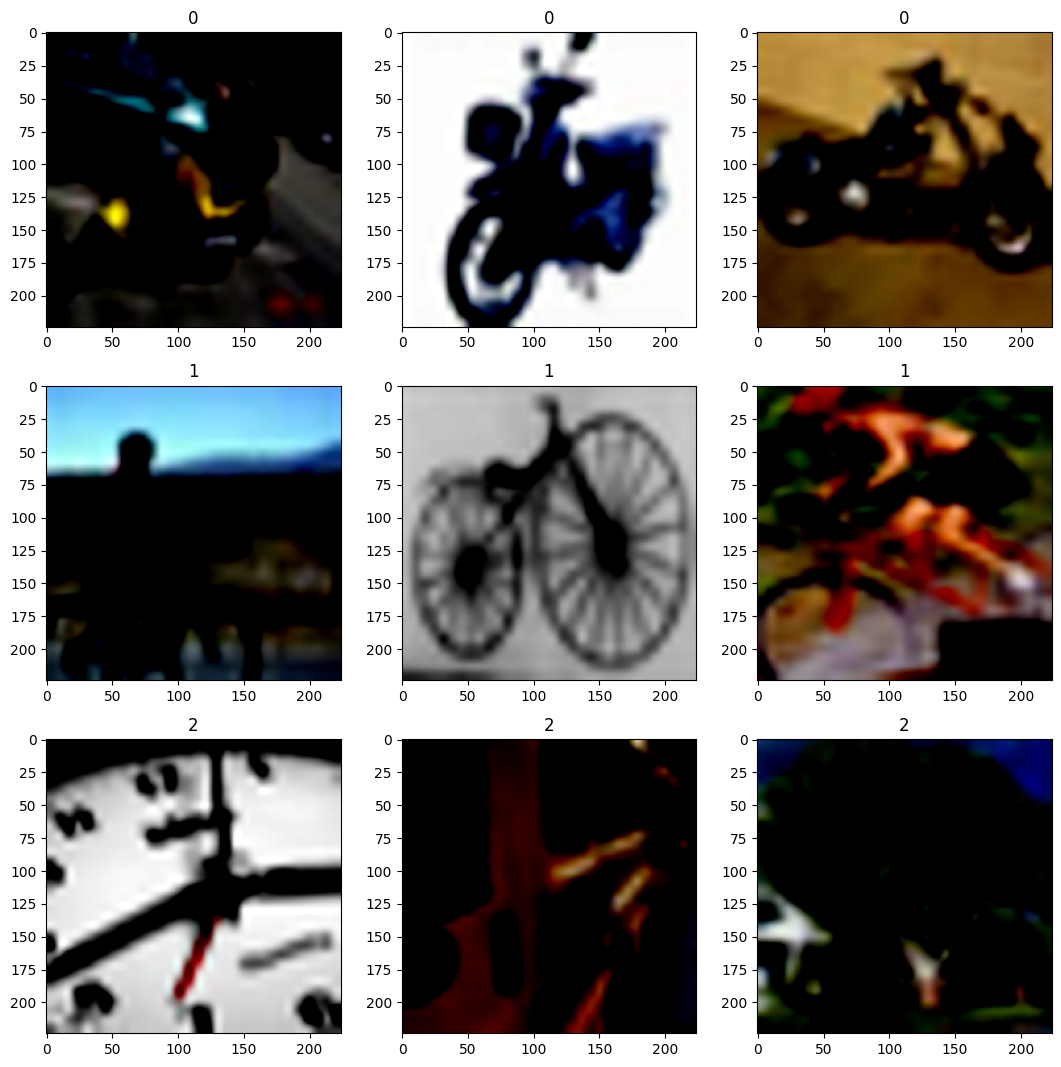

In [31]:
plot_model_preds(preds.label_ids, np.argmax(preds.predictions, axis=1), test_dataset)

## To GreyScale

In [32]:
input_emb = model.vit.embeddings.patch_embeddings.projection.weight.data

In [33]:
input_emb.shape

torch.Size([768, 3, 16, 16])

## Возьмем greyscale коэффициенты из opencv greyscale - [0.114, 0.587, 0.299] 

In [34]:
new_weigths = (input_emb[:, 0] * 0.114 + input_emb[:, 1] * 0.587 + input_emb[:, 2] * 0.299).unsqueeze(1)
new_weigths.shape

torch.Size([768, 1, 16, 16])

## Создадим новый слой nn.Conv2d c полученными весами и в конфигах ViT поменяем num_channels=1

In [35]:
new_projection = torch.nn.Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
new_projection.weight.data = new_weigths

In [36]:
#chage num_channels in ViT models config
model.vit.embeddings.patch_embeddings.projection = new_projection
model.config.num_channels = 1
model.vit.embeddings.patch_embeddings.num_channels = 1
model.to('cuda');

In [37]:
normalize = v2.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_grey_test_transforms = v2.Compose([
    v2.Resize(size, interpolation=v2.InterpolationMode.BICUBIC), 
    v2.ToTensor(), 
    normalize,
    v2.Grayscale(num_output_channels=1)])

def grey_test_transforms(examples):
    examples["pixel_values"] = [_grey_test_transforms(img) for img in examples["pixel_values"]]
    return examples

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [38]:
grey_test_dataset = test_dataset.with_transform(grey_test_transforms)

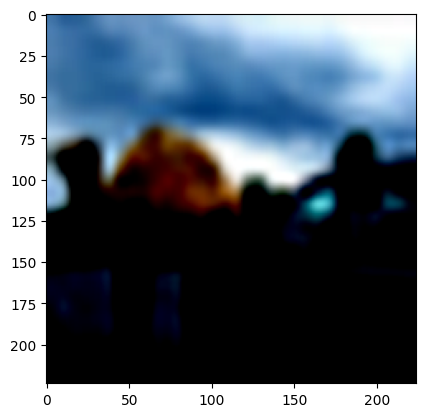

In [39]:
import numpy as np

random_idx = np.random.randint(0, len(test_dataset))
npimg = test_dataset[random_idx]['pixel_values'].numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

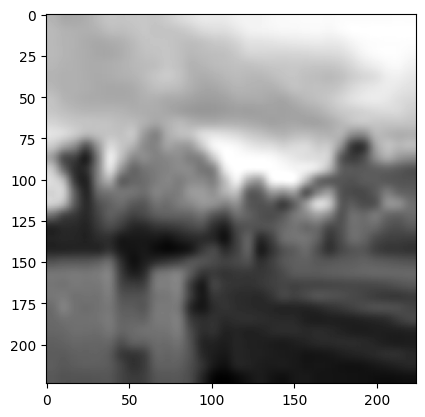

In [40]:
npimg = grey_test_dataset[random_idx]['pixel_values'].numpy()
plt.imshow(npimg.squeeze(0), cmap='gray')
plt.show()

## На predict выдаем grey_test_dataset

In [41]:
preds = trainer.predict(grey_test_dataset)
gt = np.array([item['label'] for item in test_dataset])

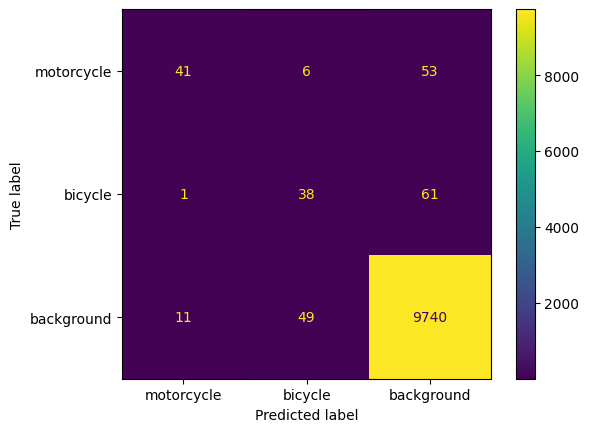

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(preds.label_ids, np.argmax(preds.predictions, axis=1), labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["motorcycle", "bicycle", "background"])
disp.plot()
plt.show()

In [48]:
{
    "acc": balanced_accuracy_score(y_true=preds.label_ids, y_pred=np.argmax(preds.predictions, axis=1)), 
    'f1': f1_score(y_true=preds.label_ids, y_pred=np.argmax(preds.predictions, axis=1), average="weighted") 
}

{'acc': 0.5946258503401362, 'f1': 0.9806212044894677}

In [45]:
def plot_grey_model_preds(gt, preds, ds):
    motocycle_in_gt = np.where(gt == 0)[0]
    bicycle_in_gt = np.where(gt == 1)[0]
    back_in_gt = np.where(gt == 2)[0]
    
    fig, axs = plt.subplots(3, 3, figsize=(13, 13))
    
    for idx, pred_class in enumerate([motocycle_in_gt, bicycle_in_gt, back_in_gt]):
        random_idx = np.random.randint(0, len(pred_class), 3)
        for j in range(3):
            npimg = ds[pred_class[random_idx[j]].item()]['pixel_values'].numpy()
            axs[idx][j].imshow(npimg.squeeze(0), cmap='gray')
            axs[idx][j].set_title(preds[pred_class[random_idx[j].item()]])
    
    plt.show()

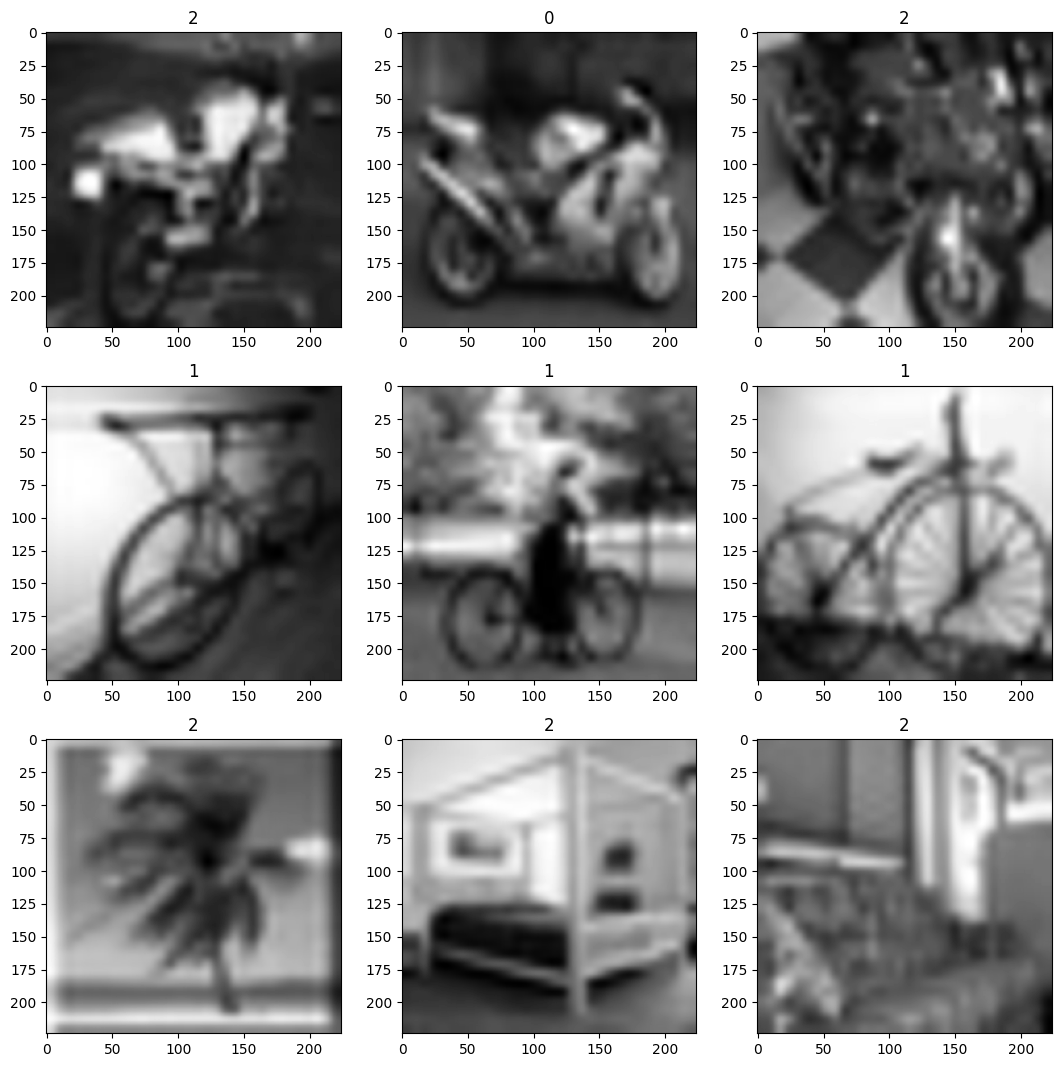

In [46]:
plot_grey_model_preds(preds.label_ids, np.argmax(preds.predictions, axis=1), grey_test_dataset)

In [47]:
#save tb logs and weights
!zip -r cifar_vit.zip /kaggle/working/cifar_vit_vechicle_0
!zip -r vit_224.zip /kaggle/working/vit_224

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/cifar_vit_vechicle_0/ (stored 0%)
  adding: kaggle/working/cifar_vit_vechicle_0/checkpoint-325/ (stored 0%)
  adding: kaggle/working/cifar_vit_vechicle_0/checkpoint-325/scheduler.pt (deflated 56%)
  adding: kaggle/working/cifar_vit_vechicle_0/checkpoint-325/preprocessor_config.json (deflated 47%)
  adding: kaggle/working/cifar_vit_vechicle_0/checkpoint-325/training_args.bin (deflated 52%)
  adding: kaggle/working/cifar_vit_vechicle_0/checkpoint-325/model.safetensors (deflated 7%)
  adding: kaggle/working/cifar_vit_vechicle_0/checkpoint-325/trainer_state.json (deflated 80%)
  adding: kaggle/working/cifar_vit_vechicle_0/checkpoint-325/config.json (deflated 49%)
  adding: kaggle/working/cifar_vit_vechicle_0/checkpoint-325/rng_state.pth (deflated 25%)
  adding: kaggle/working/cifar_vit_vechicle_0/checkpoint-325/optimizer.pt (deflated 8%)
  adding: kaggle/working/vit_224/ (stored 0%)
  adding: kaggle/working/vit_224/events.out.tfevents.1734643820.b5d70342d4ce.23.0 (

## Потренируем resnet50 и convnext (последняя, сравнима по метрикам и кол-вом параметров с ViT)

In [49]:
ckpt = "microsoft/resnet-50"

resnet_image_processor = AutoImageProcessor.from_pretrained(ckpt)
resnet_model = AutoModelForImageClassification.from_pretrained(
    ckpt,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

resnet_model.to('cuda');

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([3, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
normalize = v2.Normalize(mean=resnet_image_processor.image_mean, std=resnet_image_processor.image_std)
size = (
    resnet_image_processor.size["shortest_edge"]
    if "shortest_edge" in resnet_image_processor.size
    else (resnet_image_processor.size["height"], resnet_image_processor.size["width"])
)
#TODO: add more augs
_train_transforms = v2.Compose([
    v2.Resize(size, interpolation=v2.InterpolationMode.BICUBIC),
    v2.ColorJitter(brightness=0.75, hue=0.5), 
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomAffine(degrees=(0, 20)),
    v2.ToTensor(),
    T.ToDtype(torch.float32, scale=1),
    normalize
])
_test_transforms = v2.Compose([v2.Resize(size, interpolation=v2.InterpolationMode.BICUBIC), v2.ToTensor(), normalize])

def train_transforms(example):
    example["pixel_values"] = _train_transforms(example['pixel_values'])
    return example

def test_transforms(example):
    example["pixel_values"] = _test_transforms(example['pixel_values'])
    return example

data_collator = DefaultDataCollator()

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [51]:
train_dataset = train_dataset.with_transform(train_transforms)
filtered_train_dataset = filtered_train_dataset.with_transform(train_transforms)
test_dataset = test_dataset.with_transform(test_transforms)

In [52]:
training_args = TrainingArguments(
    output_dir="cifar_resnet50_vechicle_0",
    remove_unused_columns=True,
    eval_strategy="steps",
    eval_steps=125,
    save_strategy="steps",
    learning_rate=5e-5,
    per_device_train_batch_size=128,
    #gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    #max_steps=100,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_acc",
    report_to='tensorboard',
    logging_dir='resnet50'
)

trainer = Trainer(
    model=resnet_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=filtered_train_dataset,
    eval_dataset=test_dataset,
    processing_class=resnet_image_processor,
    compute_metrics=compute_metrics,
)

In [53]:
trainer.train()

Step,Training Loss,Validation Loss,Acc,F1
125,0.928900,0.741012,0.366599,0.972311
250,0.614700,0.365754,0.708333,0.985736
375,0.348600,0.189107,0.841939,0.983754
500,0.262900,0.133701,0.855374,0.984423
625,0.231200,0.111312,0.875714,0.985814
750,0.186000,0.103876,0.869116,0.985784


TrainOutput(global_step=850, training_loss=0.4606126361734727, metrics={'train_runtime': 1283.6557, 'train_samples_per_second': 80.941, 'train_steps_per_second': 0.662, 'total_flos': 2.2065506925815808e+18, 'train_loss': 0.4606126361734727, 'epoch': 50.0})

In [54]:
preds = trainer.predict(test_dataset)

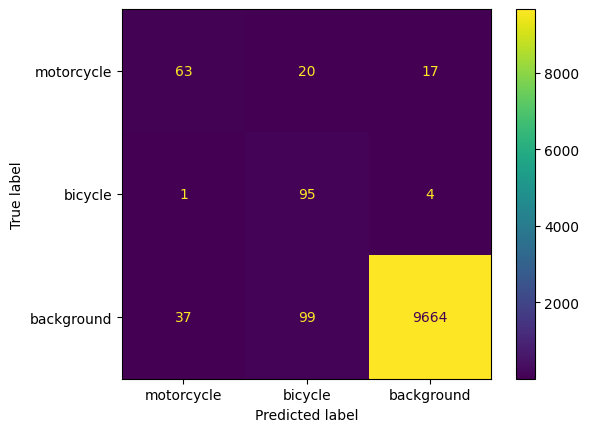

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(preds.label_ids, np.argmax(preds.predictions, axis=1), labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["motorcycle", "bicycle", "background"])
disp.plot()
plt.show()

In [56]:
{
    "acc": balanced_accuracy_score(y_true=preds.label_ids, y_pred=np.argmax(preds.predictions, axis=1)), 
    'f1': f1_score(y_true=preds.label_ids, y_pred=np.argmax(preds.predictions, axis=1), average="weighted") 
}

{'acc': 0.8553741496598639, 'f1': 0.9844232816197813}

## Резнет чуть хуже ViT

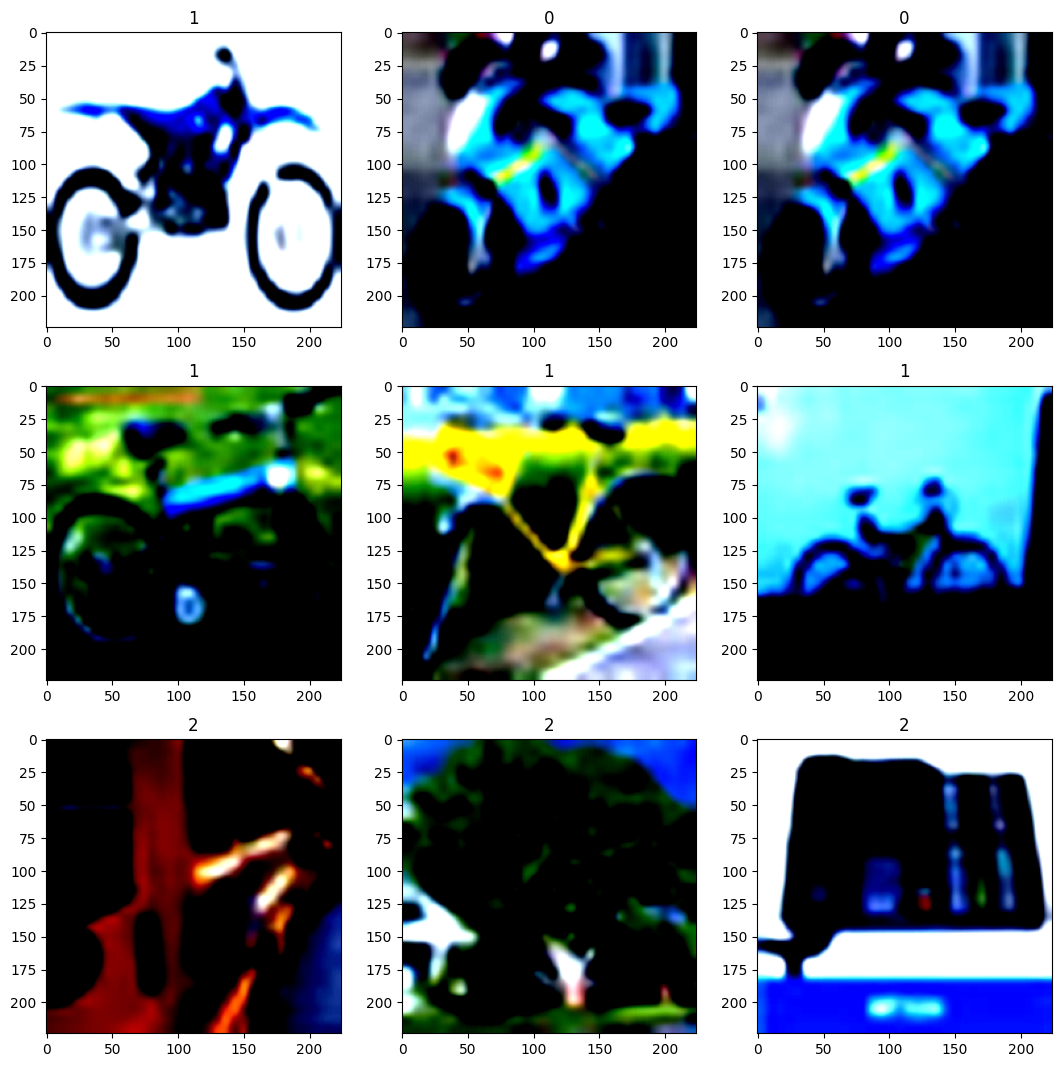

In [58]:
def plot_model_preds(gt, preds, ds):
    motocycle_in_gt = np.where(gt == 0)[0]
    bicycle_in_gt = np.where(gt == 1)[0]
    back_in_gt = np.where(gt == 2)[0]
    
    fig, axs = plt.subplots(3, 3, figsize=(13, 13))
    
    for idx, pred_class in enumerate([motocycle_in_gt, bicycle_in_gt, back_in_gt]):
        random_idx = np.random.randint(0, len(pred_class), 3)
        for j in range(3):
            npimg = ds[pred_class[random_idx[j]].item()]['pixel_values'].numpy()
            axs[idx][j].imshow(np.transpose(npimg, (1, 2, 0)))
            axs[idx][j].set_title(preds[pred_class[random_idx[j].item()]])
    
    plt.show()

plot_model_preds(preds.label_ids, np.argmax(preds.predictions, axis=1), test_dataset)

In [59]:
#save tb logs and weights
!zip -r resnet.zip /kaggle/working/resnet50

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/resnet50/ (stored 0%)
  adding: kaggle/working/resnet50/events.out.tfevents.1734645350.b5d70342d4ce.23.1 (deflated 67%)
